<b>研究目的：</b>  

本文参考海通证券冯佳睿、袁林青撰写的《选股因子系列研究(十八)——价格形态选股因子》，根据研报分析，主要测试了开盘冲高、盘低回升以及均价偏离这三种价格类因子。基于该文章，本文对文章中提到的三种价格类因子进行因子有效性分析，从而实现对股票未来收益的预测，为 alpha 因子的挖掘提供了一定思路。 

<b>研究内容：</b>  

（1）构建分别以月和半月为观察期的三种价格类因子；  
（2）对构建出来的因子进行因子有效性分析，分别包括因子 IC/IR 分析，分层回测组合分析等，并根据结果分析因子的预测能力以及不同观察期对预测能力的影响；   
（3）对每个因子，加入行业、市值、贝塔、动量、残差波动率以及非线性市值这 6 个因子进行正交化处理，分析正交化后因子对组合收益的贡献及其预测效果；  
（4）对因子进行多因子模型回测分析，分析不同因子对组合收益带来的贡献等。 

<b>研究结论：</b>  

（1）通过对这三种价格类因子的因子有效性分析结果来看，三种因子均有较好的选股能力，针对不同的观察期，月度因子比半月度因子具有更强的选股能力，但是相对而言，这三种因子的分层回测单调性不足；  
（2）通过将这三种因子与行业、市值、贝塔、动量、残差波动率以及非线性市值这 6 个因子进行正交化处理，分析结果可知正交化因子预测稳定性得到较大提升，因子的分层回测单调性得到增强；  
（3）对多因子模型进行回测分析，分别从横截面收益率回归和纯多头组合这两方面进行分析，根据分析结果来看，在加入因子 HighOpen 或者因子 VwapClose 后，模型收益能力和风险控制能力相比原始模型均得到了较大提升。

# 1 因子构建

通过对 K 线的研究，不难发现，常见价格信息，如高、开、低、收等，也能够很好地实现对股票收益的刻画，且对于大多数散户而言，K 线是其主要研究对象，从中提取特征信息，如 K 线的上影线、下影线等等。  
参考研报内容，考虑引入开盘、盘高、盘低以及均价构建相关指标刻画股票日内的形态特征。共引入三个指标：开盘冲高、盘低回升以及均价偏离。具体指标计算方式如下所示：  
（1）开盘冲高：log(盘高/开盘价)。该指标越大，表示股票盘中冲高幅度越大。  
（2）盘低回升：log(收盘价/盘低)。该指标越大，表示股票从盘低回升的幅度也就越大。  
（3）均价偏离：log(均价/收盘价)。该指标体现了股票成交均价相对于收盘价的偏离。  
紧接着，设计因子实现上述指标，在每个月或者每半个月的时间窗口下，计算上述三个因子过去 1 个月或者半个月的均值，具体计算公式如下所示：  
<center> $ HighOpen = 1/K * \sum_{i=t-k}^{t-1}log(high_i / open_i)$ </center>
<center> $ CLoseLow = 1/K * \sum_{i=t-k}^{t-1}log(close_i / low_i)$ </center>
<center> $ VwapClose = 1/K * \sum_{i=t-k}^{t-1}log(vwap_i / close_i)$ </center>

## 1.1 日期列表获取

在每个月的月末对因子数据进行提取，因此需要对每个月的月末日期进行统计。  
输入参数分别为 peroid、start_date 和 end_date，其中 peroid 进行周期选择，可选周期为周(W)、月(M)和季(Q)，start_date和end_date 分别为开始日期和结束日期。  
函数返回值为对应的日期。本文选取开始日期为 2013.1.1，结束日期为 2018.1.1。周期如月取 “W”，半月取 “2W”。

In [1]:
# 风险及免责提示：该策略由聚宽用户在聚宽社区分享，仅供学习交流使用。
# 原文一般包含策略说明，如有疑问请到原文和作者交流讨论。
# 原文网址：https://www.joinquant.com/view/community/detail/21927
# 标题：选股因子系列：价格形态选股因子

from jqdata import *
import datetime
import pandas as pd
import numpy as np
from six import StringIO
import warnings
import time
import pickle
import scipy.stats as st
from jqfactor import winsorize_med
from jqfactor import neutralize
from jqfactor import standardlize
import statsmodels.api as sm
import seaborn as sns
warnings.filterwarnings("ignore")

In [2]:
#获取指定周期的日期列表 'W、M、Q'
def get_period_date(peroid,start_date, end_date):
    #设定转换周期period_type  转换为周是'W',月'M',季度线'Q',五分钟'5min',12天'12D'
    stock_data = get_price('000001.XSHE',start_date,end_date,'daily',fields=['close'])
    #记录每个周期中最后一个交易日
    stock_data['date']=stock_data.index
    #进行转换，周线的每个变量都等于那一周中最后一个交易日的变量值
    period_stock_data=stock_data.resample(peroid,how='last')
    date=period_stock_data.index
    pydate_array = date.to_pydatetime()
    date_only_array = np.vectorize(lambda s: s.strftime('%Y-%m-%d'))(pydate_array )
    date_only_series = pd.Series(date_only_array)
    start_date = datetime.datetime.strptime(start_date, "%Y-%m-%d")
    start_date=start_date-datetime.timedelta(days=1)
    start_date = start_date.strftime("%Y-%m-%d")
    date_list=date_only_series.values.tolist()
    date_list.insert(0,start_date)
    return date_list

## 1.2 股票列表获取

股票池: 全 A 股  
股票筛选：剔除 ST 股票，剔除上市 3 个月内的股票，每只股票视作一个样本  

In [3]:
#去除上市距beginDate不足 3 个月的股票
def delect_stop(stocks,beginDate,n=30*3):
    stockList = []
    beginDate = datetime.datetime.strptime(beginDate, "%Y-%m-%d")
    for stock in stocks:
        start_date = get_security_info(stock).start_date
        if start_date < (beginDate-datetime.timedelta(days = n)).date():
            stockList.append(stock)
    return stockList

#获取股票池
def get_stock_A(begin_date):
    begin_date = str(begin_date)
    stockList = get_index_stocks('000002.XSHG',begin_date)+get_index_stocks('399107.XSHE',begin_date)
    #剔除ST股
    st_data = get_extras('is_st', stockList, count = 1, end_date=begin_date)
    stockList = [stock for stock in stockList if not st_data[stock][0]]
    #剔除停牌、新股及退市股票
    stockList = delect_stop(stockList, begin_date)
    return stockList

## 1.3 数据获取

参考上面实现因子构建的公式，在每个月以及每半个月最后一天，分别根据对应的时间窗口，对因子进行计算，并将计算得到的因子数据分别保存在变量 factorData_M 以及 factorData_2W 中。

In [4]:
start = time.clock()
# 时间窗口
N = 20
begin_date = '2013-01-01'
end_date = '2018-01-01'
# 获取月度日期列表
dateList = get_period_date('M',begin_date, end_date)
factorData_M = {}
for date in dateList:
    stockList = get_stock_A(date)
    # 获取价格类数据
    df_data = get_price(stockList, count = N, end_date = date, frequency='1d', fields=['high', 'open', 'low', 'close', 'avg'])
    # 因子计算
    temp1 = log(df_data["high"] / df_data["open"]).mean()
    temp2 = log(df_data["close"] / df_data["low"]).mean()
    temp3 = log(df_data["avg"] / df_data["close"]).mean()
    tempData = pd.DataFrame()
    tempData["HighOpen"] = temp1
    tempData["CloseLow"] = temp2
    tempData["VwapClose"] = temp3
    tempData = standardlize(tempData, axis=0)
    factorData_M[date] = tempData
elapsed = (time.clock() - start)
print("Time used:",elapsed)


('Time used:', 105.55157799999999)


In [5]:
start = time.clock()
N = 10
begin_date = '2013-01-01'
end_date = '2018-01-01'
# 获取半月日期列表
dateList = get_period_date('2W',begin_date, end_date)
factorData_2W = {}
for date in dateList:
    stockList = get_stock_A(date)
    # 获取价格类数据
    df_data = get_price(stockList, count = N, end_date = date, frequency='1d', fields=['high', 'open', 'low', 'close', 'avg'])
    # 因子计算
    temp1 = log(df_data["high"] / df_data["open"]).mean()
    temp2 = log(df_data["close"] / df_data["low"]).mean()
    temp3 = log(df_data["avg"] / df_data["close"]).mean()
    tempData = pd.DataFrame()
    tempData["HighOpen"] = temp1
    tempData["CloseLow"] = temp2
    tempData["VwapClose"] = temp3
    tempData = standardlize(tempData, axis=0)
    factorData_2W[date] = tempData
elapsed = (time.clock() - start)
print("Time used:",elapsed)


('Time used:', 216.62505500000003)


# 2 因子有效性分析

## 2.1 因子 IC 分析

因子 k 的 IC 值一般是指个股第 T 期在因子 k 上的暴露度与 T + 1 期的收益率的相关系数。当得到因子 IC 值序列后，根据以下分析方法进行计算:  
（1）IC 值序列的均值: 判断因子有效性;  
（2）IC 值系列的均值与标准差比值（IR）：分析分析有效性  
常见 IC 分析方式分为以下两种：normal IC 以及 rank IC，接下来从这两个角度，对不同因子的 IC 以及 IR 进行分析。

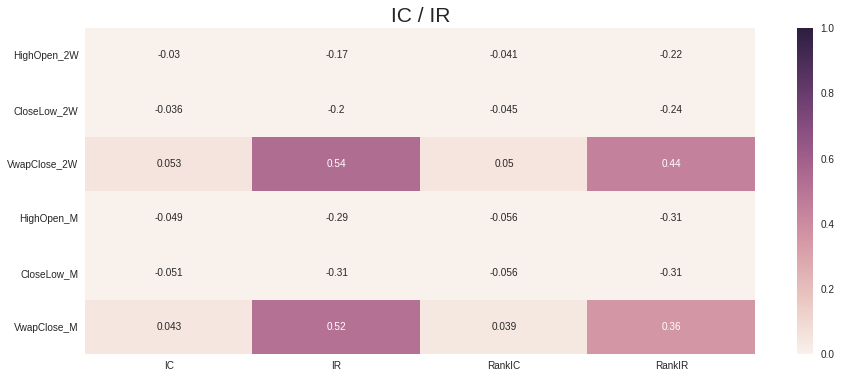

In [6]:
def factor_IC_analysis(factorData, Field, begin_date, end_date, period):  
    dateList = get_period_date(period,begin_date, end_date)
    IC_norm = {}
    IC_rank = {}
    R_T = pd.DataFrame()
    for date in dateList[:-1]:
        #取股票池
        stockList = list(factorData[date].index)
        #获取横截面收益率
        df_close=get_price(stockList, date, dateList[dateList.index(date)+1], 'daily', ['close'])
        if df_close.empty:
            continue
        df_pchg=df_close['close'].iloc[-1,:]/df_close['close'].iloc[0,:]-1
        R_T['pchg']=df_pchg
        #获取因子数据
        factor_data = factorData[date][Field]
        #数据标准化
        factor_data = standardlize(factor_data, inf2nan=True, axis=0)
        R_T['factor'] = factor_data
        R_T = R_T.dropna()
        IC_norm[date]=st.pearsonr(R_T.pchg, R_T['factor'])[0]
        IC_rank[date]=st.pearsonr(R_T.pchg.rank(), R_T['factor'].rank())[0]
    IC_norm = pd.Series(IC_norm).dropna()
    IC_rank = pd.Series(IC_rank).dropna()
    return (IC_norm, IC_rank)
# 因子 IC 分析
IndexList = ["HighOpen_2W", "CloseLow_2W", "VwapClose_2W", "HighOpen_M", "CloseLow_M", "VwapClose_M"]
ColumnsList = ["IC", "IR", "RankIC", "RankIR"]
IC = pd.DataFrame(index = IndexList, columns = ColumnsList)
for i in ["2W", "M"]:
    for j in ["HighOpen", "CloseLow", "VwapClose"]:
        if i == "2W":
            tempIC = factor_IC_analysis(factorData_2W, j, begin_date, end_date, i)
        if i == "M":
            tempIC = factor_IC_analysis(factorData_M, j, begin_date, end_date, i)
        # 分析结果保存
        IC.loc[j + "_" + i, "IC"] = tempIC[0].mean()
        IC.loc[j + "_" + i, "IR"] = tempIC[0].mean() / tempIC[0].std()
        IC.loc[j + "_" + i, "RankIC"] = tempIC[1].mean()
        IC.loc[j + "_" + i, "RankIR"] = tempIC[1].mean() / tempIC[1].std()
IC = IC.astype(float)
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
sns.heatmap(IC, annot=True, vmax=1, vmin = 0)
ax.set_title("IC / IR", fontsize=21)
fig.show()

上表给出的结果为以月为周期的三个因子以及以半月为周期的三个因子的 IC、IR 以及 Rank IC、Rank IR 的值，根据表中结果可知，各因子都有较强的选股能力，具体可得到的结论如下所示：  
（1）因子 HighOpen 与 VwapClose 均为正向因子，而因子 CloseLow 与他们的方向相反，为反向因子。  
（2）对于因子 HighOpen 与 VwapClose 而言，以月为周期的预测能力明显更强于以半月为周期；对于因子 CloseLow 而言，以半月为周期的预测能力更强于以月为周期。  
（3）以半月为周期时，三个因子的 normal IC 绝对值均能够达到 0.03，以月为周期时，三个因子的 normal IC 绝对值能够达到 0.4 以上。此外。从 IR 来看，相对而言以月为周期有着更为明显的提升。

## 2.2 分层组合回测分析

为了进一步分析因子有效性，本文对该因子进行分层回测分析，策略步骤如下所示：  
（1）在每个月或者每半个月最后一个交易日，统计全 A 股因子的值；  
（2）根据因子值按照从小到大的顺序排序，并将其等分为 10 组；  
（3）每个调仓日对每组股票池进行调仓交易，从而获得 10 组股票组合的月均收益。  
首先，对以月为调仓期的情况进行分析。

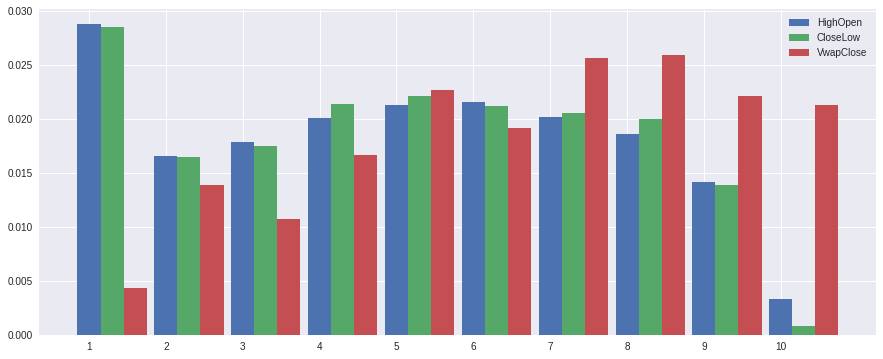

In [7]:
def GetPchg(i, factorData, Field, begin_date, end_date, period):
    dateList = get_period_date(period,begin_date, end_date)
    pchg = []
    # 交易手续费
    cost = 0.002
    for date in dateList[:-1]:
        tempData = factorData[date].copy()
        # 因子排序
        tempData = tempData.sort(Field)
        stockList = list(tempData.index)
        # 获取交易股票池
        stocks = stockList[int(len(stockList)*(i-1)/10):int(len(stockList)*i/10)]
        df_close = get_price(stocks, date, dateList[dateList.index(date)+1], 'daily', ['close'])['close']
        pchg.append(np.mean(df_close.iloc[-1] / df_close.iloc[0] - 1) - cost)
    return pchg
# 分层组合回测
pchg_M = {}
fig = plt.figure(figsize=(15,6))
bar_width = 0.3
x = np.array(range(1,11))
for j in ["HighOpen", "CloseLow", "VwapClose"]:
    tempPchg = []
    for k in range(1,11):
        pchg_M[j+str(k)] = GetPchg(k, factorData_M, j, begin_date, end_date, "M")
        tempPchg.append(np.mean(pchg_M[j+str(k)]))
    plt.bar(x, tempPchg, bar_width, label = j)
    x = x + bar_width
plt.xticks(range(1, len(tempPchg)+1))
# 添加图例
plt.legend()
plt.show()



上图展示的是以月为周期时，各个组合的月均收益情况，从分组收益可以看出，因子 HighOpen 以及 CloseOpen除了组合 1 外，其他组合基本符合两边组别收益低，中间组别收益高的非线性趋势，因子 VwapClose 基本符合这样的情况。  
接下来，对以半月为调仓期的情况进行具体分析。

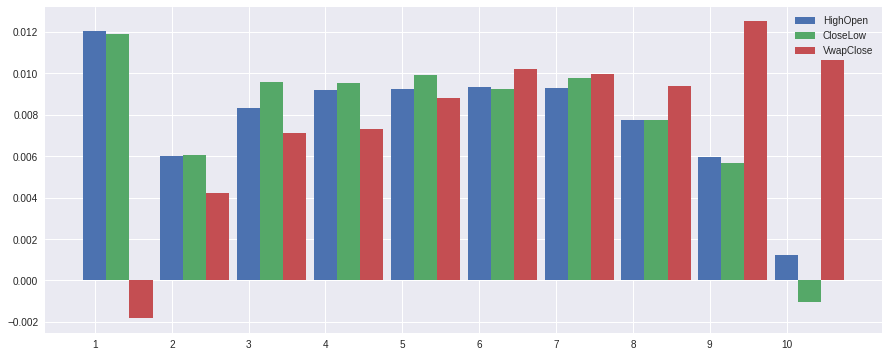

In [8]:
pchg_2W = {}
fig = plt.figure(figsize=(15,6))
bar_width = 0.3
x = np.array(range(1,11))
for j in ["HighOpen", "CloseLow", "VwapClose"]:
    tempPchg = []
    for k in range(1,11):
        pchg_2W[j+str(k)] = GetPchg(k, factorData_2W, j, begin_date, end_date, "2W")
        tempPchg.append(np.mean(pchg_2W[j+str(k)]))
    plt.bar(x, tempPchg, bar_width, label = j)
    x = x + bar_width
plt.xticks(range(1, len(tempPchg)+1))
# 添加图例
plt.legend()
plt.show()


上图展示的以半月为调仓期的组合情况，从图中可知，基本上走势和以月为调仓期的情况相似，但是，以半月为调仓期的组合比以月为调仓期的组合月均收益更低，该结论与 IC 分析的结果一致。  
接下来，对于每个组合的情况，通过下表的具体月均收益进行提现。

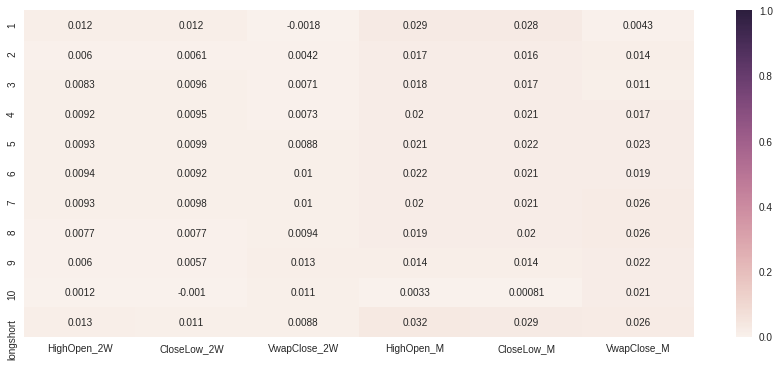

In [9]:
# 分层组合回测的具体数据以及多空组合
IndexList = range(1,11) + ["longshort"]
ColumnsList = ["HighOpen_2W", "CloseLow_2W", "VwapClose_2W", "HighOpen_M", "CloseLow_M", "VwapClose_M"]
result = pd.DataFrame(index = IndexList, columns = ColumnsList)
for i in ["2W", "M"]:
    for j in ["HighOpen", "CloseLow", "VwapClose"]:
        for k in range(1,11):
            if i == "2W":
                temp = np.mean(pchg_2W[j+str(k)])
                result.loc[k, j+"_"+i] = temp
                # 获取多空组合数据
                result.loc["longshort", j+"_"+i] = np.mean(pchg_2W[j+str(1)]) + np.mean(pchg_2W[j+str(10)]) 
            if i == "M":
                temp = np.mean(pchg_M[j+str(k)])
                result.loc[k, j+"_"+i] = temp 
                # 获取多空组合数据
                result.loc["longshort", j+"_"+i] = np.mean(pchg_M[j+str(1)]) + np.mean(pchg_M[j+str(10)]) 
result = result.astype(float)
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
sns.heatmap(result, annot=True, vmax=1, vmin = 0)
fig.show()


上表展示了不同组合的月均收益以及对应的多空组合，从多空组合收益来看，三个因子均在以月为调仓期的情况下能够获得更高的收益，且因子 HighOpen > CloseLow > VwapClose。  
接下来，对不同因子不同构建期的组合，选择前 10% 股票构建的组合每年收益以及胜率（是否获得正收益）进行分析。

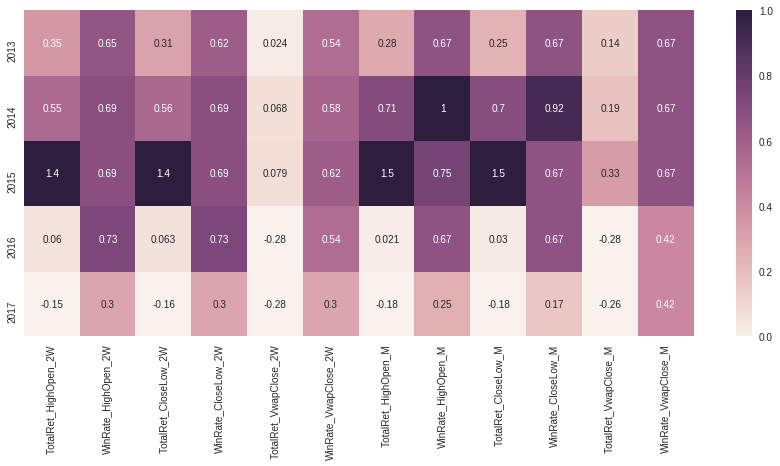

In [10]:
IndexList = ["2013", "2014", "2015", "2016", "2017"]
result = pd.DataFrame(index = IndexList)
for period in ["2W", "M"]:
    for factor in ["HighOpen", "CloseLow", "VwapClose"]:
        rate = []
        ret = []
        for k in range(len(IndexList)):
            if period == "2W":
                temp = pchg_2W[factor+str(1)][k*len(pchg_2W[factor+str(1)])/len(IndexList):(k+1)*len(pchg_2W[factor+str(1)])/len(IndexList)]
                rate.append(len([i for i in temp if i>0]) / float(len(temp)))
                tempSum = 1
                for a in temp:
                    tempSum *= 1+a
                ret.append(tempSum - 1)
            if period == "M":
                temp = pchg_M[factor+str(1)][k*len(pchg_M[factor+str(1)])/len(IndexList):(k+1)*len(pchg_M[factor+str(1)])/len(IndexList)]
                rate.append(len([i for i in temp if i>0]) / float(len(temp)))
                tempSum = 1
                for a in temp:
                    tempSum *= 1+a
                ret.append(tempSum - 1)
        result["TotalRet_" + factor + "_" + period] = ret
        result["WinRate_" + factor + "_" + period] = rate

result = result.astype(float)
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
sns.heatmap(result, annot=True, vmax=1, vmin = 0)
fig.show()


上表展示了不同组合的每年收益以及对应的胜率，从表中可以看出：  
（1）每个组合均在除 2017 年以外的每一年获得正收益且胜率基本上大于 60%；  
（2）以月为调仓期的组合能够获得很明显更高的收益。

# 3 因子正交化处理

第 2 章对因子的有效性进行了具体分析，但是考虑到分层回测的单调性不好，因此引用行业、市值、贝塔、动量、残差波动率以及非线性市值 6 个因子，进行正交处理并构建对应的正交因子，然后对正交因子进行因子有效性分析。

## 3.1 数据获取

In [11]:
start = time.clock()
begin_date = '2013-01-01'
end_date = '2018-01-01'
dateList = get_period_date('M',begin_date, end_date)
for date in dateList:
    tempData = factorData_M[date]
    # 对原始因子进行中性化处理
    tempData = neutralize(tempData, how=["sw_l1", "size", "beta", "momentum", "residual_volatility", "non_linear_size"], date=date, axis=0, fillna=None, add_constant=False)
    factorData_M[date] = tempData
elapsed = (time.clock() - start)
print("Time used:",elapsed)


('Time used:', 95.68705699999987)


In [12]:
start = time.clock()
begin_date = '2013-01-01'
end_date = '2018-01-01'
dateList = get_period_date('2W',begin_date, end_date)
for date in dateList:
    tempData = factorData_2W[date]
    # 对原始因子进行中性化处理
    tempData = neutralize(tempData, how=["sw_l1", "size", "beta", "momentum", "residual_volatility", "non_linear_size"], date=date, axis=0, fillna=None, add_constant=False)
    factorData_2W[date] = tempData
elapsed = (time.clock() - start)
print("Time used:",elapsed)


('Time used:', 211.58337600000004)


## 3.2 因子有效性分析

### 3.2.1 因子 IC 分析

首先，对正交化后的各个因子进行 IC 分析，分析内容和前面类似。 

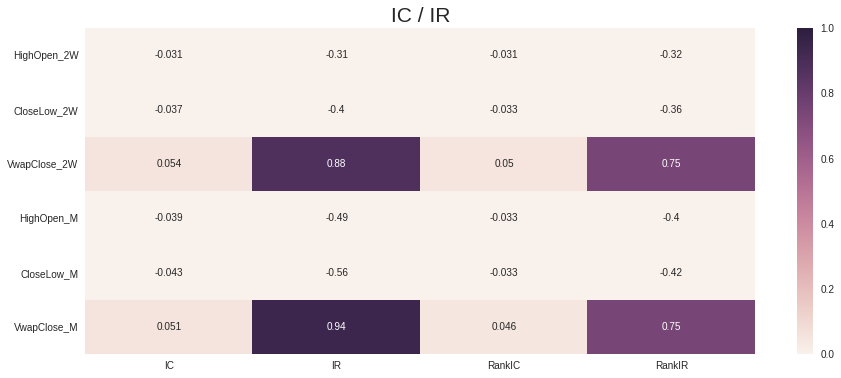

In [13]:
IndexList = ["HighOpen_2W", "CloseLow_2W", "VwapClose_2W", "HighOpen_M", "CloseLow_M", "VwapClose_M"]
ColumnsList = ["IC", "IR", "RankIC", "RankIR"]
IC = pd.DataFrame(index = IndexList, columns = ColumnsList)
for i in ["2W", "M"]:
    for j in ["HighOpen", "CloseLow", "VwapClose"]:
        if i == "2W":
            # 获取 IC 分析结果
            tempIC = factor_IC_analysis(factorData_2W, j, begin_date, end_date, i)
        if i == "M":
            tempIC = factor_IC_analysis(factorData_M, j, begin_date, end_date, i)
        # 结果保存
        IC.loc[j + "_" + i, "IC"] = tempIC[0].mean()
        IC.loc[j + "_" + i, "IR"] = tempIC[0].mean() / tempIC[0].std()
        IC.loc[j + "_" + i, "RankIC"] = tempIC[1].mean()
        IC.loc[j + "_" + i, "RankIR"] = tempIC[1].mean() / tempIC[1].std()
# 结果展示
IC = IC.astype(float)
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
sns.heatmap(IC, annot=True, vmax=1, vmin = 0)
ax.set_title("IC / IR", fontsize=21)
fig.show()

上表展示了正交化后的各个因子 IC 值，从表中可以看出，正交化后因子与不进行正交化之前，IC 值变化不明显，但是 IR 得到了明显提升，可见正交化操作能够提高因子的稳定性。

### 3.2.2 分层组合回测分析

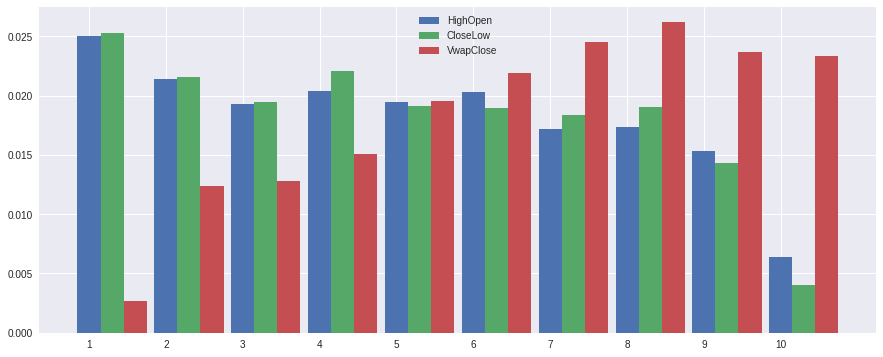

In [14]:
pchg_M = {}
fig = plt.figure(figsize=(15,6))
bar_width = 0.3
x = np.array(range(1,11))
for j in ["HighOpen", "CloseLow", "VwapClose"]:
    tempPchg = []
    # 获取分层回测结果
    for k in range(1,11):
        pchg_M[j+str(k)] = GetPchg(k, factorData_M, j, begin_date, end_date, "M")
        tempPchg.append(np.mean(pchg_M[j+str(k)]))
    plt.bar(x, tempPchg, bar_width, label = j)
    x = x + bar_width
plt.xticks(range(1, len(tempPchg)+1))
# 添加图例
plt.legend()
plt.show()


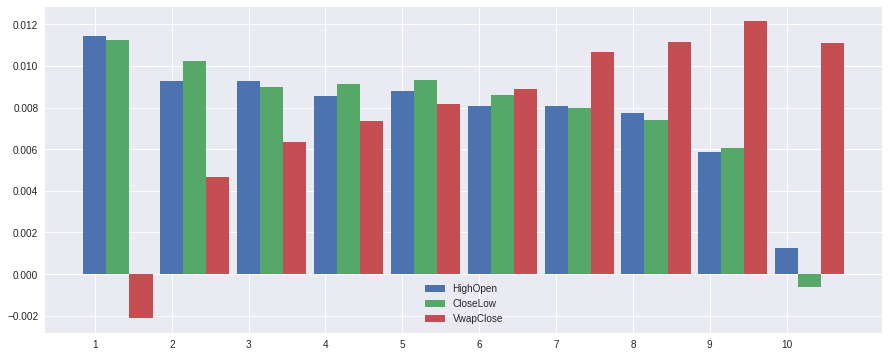

In [15]:
pchg_2W = {}
fig = plt.figure(figsize=(15,6))
bar_width = 0.3
x = np.array(range(1,11))
for j in ["HighOpen", "CloseLow", "VwapClose"]:
    tempPchg = []
    # 获取分层回测结果
    for k in range(1,11):
        pchg_2W[j+str(k)] = GetPchg(k, factorData_2W, j, begin_date, end_date, "2W")
        tempPchg.append(np.mean(pchg_2W[j+str(k)]))
    plt.bar(x, tempPchg, bar_width, label = j)
    x = x + bar_width
plt.xticks(range(1, len(tempPchg)+1))
# 添加图例
plt.legend()
plt.show()


上面两张图展示的分别是以月为调仓期和以半月为调仓期的结果，从图中可以看出，正交化后因子，分层单调性有了很明显的提升，由次可以看出正交化结果能够使得因子有效性得到进一步加强。

# 4 多因子模型回测

## 4.1 横截面收益率回归

接下来，从回归法的角度讨论因子在加入到模型后的额外选股能力具体回归方程如下所示：  
<center> $r_{i,t} = \alpha_t + \beta_{1,t}size_{i,t} + \beta_{2,t}Beta_{i,t} + \beta_{3,t}momentum_{i,t} + \beta_{4,t}residual\_volatility_{i,t}  + \beta_{5,t}non\_linear\_size_{i,t} + \epsilon_{i,t}$ </center>  
其中，size 表示市值，beta 表示股票相对于市场的波动敏感度，momentum 表示过去两年里相对强势的股票与弱势股票之间的差异，residual_volatility 表示剥离了市场风险后的波动率高低产生的收益率差异，non_linear_size 表示无法由规模因子解释的但与规模有关的收益差异。

In [16]:
from jqfactor import get_factor_values

start = time.clock()
begin_date = '2013-01-01'
end_date = '2018-01-01'
dateList = get_period_date('M',begin_date, end_date)
for date in dateList:
    tempData = factorData_M[date]
    stockList = list(tempData.index)
    # 获取 5 因子数据并保存
    temp = get_factor_values(stockList, ["size", "beta", "momentum", "residual_volatility", "non_linear_size"], end_date = date, count = 1)
    tempData["size"] = temp["size"].iloc[0]
    tempData["beta"] = temp["beta"].iloc[0]
    tempData["momentum"] = temp["momentum"].iloc[0]
    tempData["residual_volatility"] = temp["residual_volatility"].iloc[0]
    tempData["non_linear_size"] = temp["non_linear_size"].iloc[0]
    tempData = standardlize(tempData, axis=0)
    factorData_M[date] = tempData
elapsed = (time.clock() - start)
print("Time used:",elapsed)


('Time used:', 30.592061999999714)


In [17]:
def LRData(factorData, Fields):
    result_t = pd.DataFrame()
    result_params = pd.DataFrame()
    result_r2 = []
    for date in dateList[:-1]:
        R_T = pd.DataFrame()
        #取股票池
        stockList = list(factorData[date].index)
        #获取横截面收益率
        df_close = get_price(stockList, date, dateList[dateList.index(date)+1], 'daily', ['close'])
        if df_close.empty:
            continue
        df_pchg=df_close['close'].iloc[-1,:]/df_close['close'].iloc[0,:]-1
        R_T['pchg'] = df_pchg
        #获取因子数据
        factor_data = factorData[date]
        R_T[Fields] = factor_data[Fields]
        R_T = R_T.dropna()
        X = R_T[Fields]
        y = R_T['pchg']   
        # WLS回归
        wls = sm.OLS(y, X)
        result = wls.fit()
        tvalues = result.tvalues
        params = result.params
        r2 = result.rsquared_adj
        result_t[date] = tvalues
        result_params[date] = params
        result_r2.append(r2)
    result = pd.DataFrame()
    result['t 统计量'] = result_t.mean(axis = 1)
    result['因子收益率'] = result_params.mean(axis = 1)
    print "调整 r2 值: ", np.nanmean(result_r2)

    return result.T
# 对多因子模型进行回归
Fields = ["size", "beta", "momentum", "residual_volatility", "non_linear_size", "HighOpen", "CloseLow", "VwapClose"]
LRData(factorData_M, Fields)



调整 r2 值:  0.0683815804623


,size,beta,momentum,residual_volatility,non_linear_size,HighOpen,CloseLow,VwapClose
t 统计量,-2.930224,-1.232884,1.000269,-2.172425,-2.130718,-0.789071,0.323366,1.727728
因子收益率,-0.009421,-0.003106,0.003108,-0.005486,-0.005793,-0.004701,0.001457,0.005905


上表展示的结果为三个以月为调仓期的因子在加入市值、贝塔、动量、残差波动率以及非线性市值这 5 个因子后，各个因子的 t 统计量以及对应的因子收益率，根据表中结果可知，size、non_linear_size 以及 residual_volatility 对股票收益贡献最大，其次是因子 VwapClose。

## 4.2 纯多头组合

参考前面分析的模型，可分为原始模型（5 因子模型）以及添加不同因子的改进模型，基于 2013 - 2018 年这 5 年的数据，对每个模型，通过等权的方式，实现对未来收益的预测，并筛选出预测收益最高的 100 只股票，构建相对应的组合，下面对每个模型的组合进行分析。

In [18]:
def GetPchg_100(factorData, Field, begin_date, end_date):
    dateList = get_period_date('M',begin_date, end_date)
    pchg = []
    # 交易手续费
    cost = 0.002
    for date in dateList[:-1]:
        tempData = factorData[date].copy()
        # 各因子等权
        temp = -tempData["size"] - tempData["beta"] +  tempData["momentum"] - tempData["residual_volatility"] - tempData["non_linear_size"]
        if Field == "HighOpen":
            temp += -tempData["HighOpen"]
        if Field == "CloseLow":
            temp += tempData["CloseLow"]
        if Field == "VwapClose":
            temp += tempData["VwapClose"]
        # 因子排序
        temp.sort(ascending = False)
        stockList = list(temp.index)
        # 获取前 100 只股票作为股票池
        stocks = stockList[:100]
        df_close = get_price(stocks, date, dateList[dateList.index(date)+1], 'daily', ['close'])['close']
        pchg.append(np.mean(df_close.iloc[-1] / df_close.iloc[0] - 1) - cost)
    # 风险收益指标计算
    netValue = 1
    for i in pchg:
        netValue *= 1+i
    totalRet = netValue - 1
    annRet = pow(1+totalRet, 0.2) - 1
    winRate = len([i for i in pchg if i>0]) / float(len(pchg))
    volati = np.std(pchg)
    SR = (annRet - 0.04) / volati
    return [totalRet, annRet, volati, winRate, SR]

Fields = ["Origin", "HighOpen", "CloseLow", "VwapClose"]
result = pd.DataFrame(index = Fields, columns = ["TotalRet", "AnnRet", "Vola", "WinRate", "SR"])

for field in Fields:
    result.loc[field,:] = GetPchg_100(factorData_M, field, begin_date, end_date)
result


,TotalRet,AnnRet,Vola,WinRate,SR
Origin,18.4815,0.8110251,0.1048673,0.7166667,7.352388
HighOpen,24.29106,0.9080661,0.1032213,0.75,8.409755
CloseLow,9.428401,0.5982457,0.109454,0.6666667,5.100279
VwapClose,22.20143,0.875439,0.1133322,0.7166667,7.371595


上表展示了不同模型的组合收益情况，从表中可知，在加入因子 HighOpen 或者因子 VwapClose 后，模型收益能力和风险控制能力相比原始模型均得到了较大提升。加入因子 HighOpen 对模型收益贡献最大，且对应模型的波动性最低，使得模型的夏普比率在所有模型中最大。

# 结论

海通金工本篇报告的研究主要测试了三种价格类因子的选股效果，即 HighOpen、CloseLow 和 VwapClose。
本文通过上述分析，得到了以下结论：  
（1）通过对这三种价格类因子的因子有效性分析结果来看，三种因子均有较好的选股能力，针对不同的观察期，月度因子比半月度因子具有更强的选股能力，但是相对而言，这三种因子的分层回测单调性不足；  
（2）通过将这三种因子与行业、市值、贝塔、动量、残差波动率以及非线性市值这 6 个因子进行正交化处理，分析结果可知正交化因子预测稳定性得到较大提升，因子的分层回测单调性得到增强；  
（3）对多因子模型进行回测分析，分别从横截面收益率回归和纯多头组合这两方面进行分析，根据分析结果来看，在加入因子 HighOpen 或者因子 VwapClose 后，模型收益能力和风险控制能力相比原始模型均得到了较大提升。